In [1]:
%matplotlib inline

In [2]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Using Theano backend.


In [3]:
# Raw data filenames.

rawdata_file1 = '../data/raw/datatraining.txt'
rawdata_file2 = '../data/raw/datatest.txt'
outdata_file = '../data/interim/occupancy_dl-models.txt'

In [4]:
# Read in data, parsing the date column into datetime64 format, and combine
# train and test set into a single dataframe.

parse_dates = ['date']
index_col = 'ObservationID'

occupancy_df = pd.read_csv(rawdata_file1, parse_dates=parse_dates, index_col=index_col)
occupancy2_df = pd.read_csv(rawdata_file2, parse_dates=parse_dates, index_col=index_col)

occupancy_df = pd.concat([occupancy_df, occupancy2_df], ignore_index=True)
occupancy_df.index.names = [index_col]

In [5]:
# Extract data from pandas dataframes and rescale.

Y = np.array(occupancy_df['Occupancy'].values)
X = np.array(occupancy_df[['CO2', 'Light', 'Temperature', 'Humidity']])

# Get dimensions of input and output
dimof_output = int(np.max(Y) + 1)
dimof_input = X.shape[1]
print('dimof_input: ', dimof_input)
print('dimof_output: ', dimof_output)

# Scale/whiten the X data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Set y as categorical data
Y = np_utils.to_categorical(Y, dimof_output)

dimof_input:  4
dimof_output:  2


In [6]:
# Set up a 'look back' dataset for sequence to label prediction with Keras.

# The LSTM network expects the input data (X) to be provided with a specific
# array structure in the form of: [samples, time steps, features].

# create_dataset is adapted from
# http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

def create_dataset(X, Y, **options):
    """Convert an array of X, Y values into a dataset matrix for and LSTM"""
    
    look_back = options.pop('look_back', None)
    dataX, dataY = [], []
    for i in range(len(X) - look_back - 1):
        a = X[i:(i+look_back)]
        dataX.append(a)
        dataY.append(Y[i + look_back])
    return np.array(dataX), np.array(dataY)

def train_test_split_sequential(X, Y, **options):
    """Splits data into train test sets, based on a fraction test_size samples
    from the end of the timeseries"""
    
    test_size = options.pop('test_size', None)
    if test_size is None:
        test_size = 0.25
        
    n_sample = len(Y)
    n_test = int(n_sample * test_size)
        
    X_train = X[:-n_test]
    Y_train = Y[:-n_test]

    X_test = X[-n_test:]
    Y_test = Y[-n_test:]
    
    return X_train, X_test, Y_train, Y_test

# Predictions will be based on look_back minutes of data:
look_back = 45
X_all, Y_all = create_dataset(X, Y, look_back=look_back)

X_train, X_test, Y_train, Y_test = train_test_split_sequential(X_all, Y_all, test_size=0.25)

print('X training data shape = ', X_train.shape)
print('Y training data shape', Y_train.shape)

print('X test data shape = ', X_test.shape)
print('Y test data shape', Y_test.shape)

X training data shape =  (8072, 45, 4)
Y training data shape (8072, 2)
X test data shape =  (2690, 45, 4)
Y test data shape (2690, 2)


In [7]:
# Create the LSTM network.

batch_size = 32
dropout = 0.4

model = Sequential()
model.add(LSTM(output_dim=dimof_output, batch_input_shape=[batch_size, look_back, dimof_input]))
model.add(Dropout(dropout))
model.add(Dense(dimof_output, init='uniform', activation='softmax'))
model.compile(loss='mse', optimizer='rmsprop')

In [8]:
# Train model for num_epoch epochs, with an early stopping criterion.

num_epoch = 32

earlyStopping = EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')

history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    callbacks=[earlyStopping],
    nb_epoch=num_epoch, batch_size=batch_size, verbose=1)

Train on 8072 samples, validate on 2690 samples
Epoch 1/32
8072/8072 [==============================] - 1s - loss: 0.1854 - val_loss: 0.1669
Epoch 2/32
8072/8072 [==============================] - 1s - loss: 0.1091 - val_loss: 0.1033
Epoch 3/32
8072/8072 [==============================] - 1s - loss: 0.0765 - val_loss: 0.0576
Epoch 4/32
8072/8072 [==============================] - 1s - loss: 0.0616 - val_loss: 0.0380
Epoch 5/32
8072/8072 [==============================] - 1s - loss: 0.0549 - val_loss: 0.0306
Epoch 6/32
8072/8072 [==============================] - 1s - loss: 0.0478 - val_loss: 0.0279
Epoch 7/32
8072/8072 [==============================] - 1s - loss: 0.0451 - val_loss: 0.0273
Epoch 8/32
8072/8072 [==============================] - 1s - loss: 0.0414 - val_loss: 0.0280


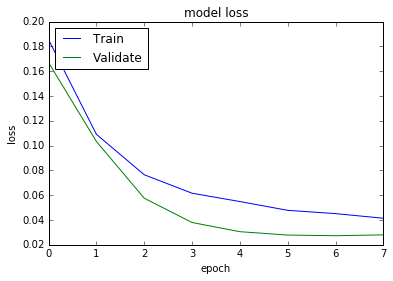

In [9]:
# Plot history for training and validation loss.

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
plt.show()

10762/10762 [==============================] - 0s     


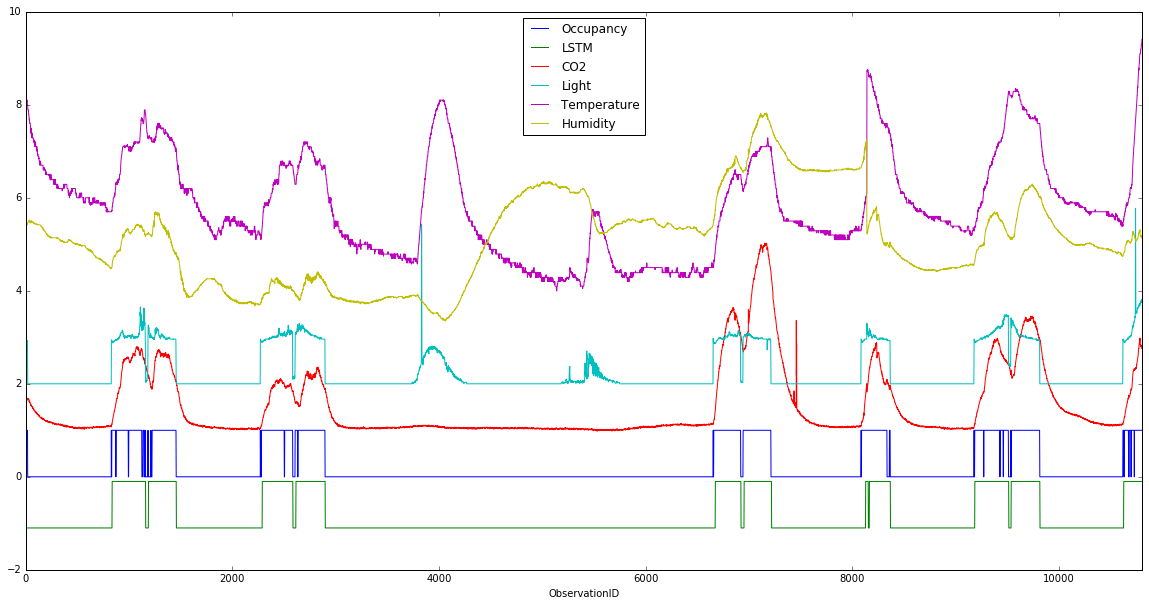

In [10]:
# Show model predictions against input occupancy labels, and input data timestreams

Y_predict = model.predict_classes(X_all, verbose=True)
series = np.hstack((np.zeros(look_back + 1, dtype=int), Y_predict))
occupancy_df['LSTM'] = pd.Series(series, index=occupancy_df.index)

occupancy_df['Occupancy'].plot(figsize=[20, 10], legend=True)
occupancy_df['LSTM'].apply(lambda x: x - 1.1).plot(legend=True)
occupancy_df['CO2'].apply(lambda x: (x - 420.)/400. + 1).plot(legend=True)
occupancy_df['Light'].apply(lambda x: x/450. + 2).plot(legend=True)
occupancy_df['Temperature'].apply(lambda x: x - 15).plot(legend=True)
occupancy_df['Humidity'].apply(lambda x: x / 5. ).plot(legend=True)

In [11]:
# Serialize model to YAML.

model_yaml = model.to_yaml()
with open('../models/model.yaml', 'w') as yaml_file:
    yaml_file.write(model_yaml)

# Serialize weights to HDF5

model.save_weights('../models/model.h5')
print('Saved model to disk')

Saved model to disk


In [12]:
# Write predictions to disk

occupancy_df.to_csv(outdata_file)